In [1]:
import pandas as pd
import numpy as np
from sklearn.decomposition import PCA

from sklearn.preprocessing import StandardScaler

from sklearn.cluster import KMeans

cities = pd.read_csv(f'./livingwage.csv') # you might need to change this path
cities = cities.dropna()
cities.head()

,rank_2020,city,state,population_2020,population_2010,land_area_sqmi,density,one_adult_no_kids_living_wage,one_adult_one_kid_living_wage,one_adult_two_kids_living_wage,one_adult_three_kids_living_wage,two_adults_one_working_no_kids_living_wage,two_adults_one_working_one_kid_living_wage,two_adults_one_working_two_kids_living_wage,two_adults_one_working_three_kids_living_wage,two_adults_both_working_no_kids_living_wage,two_adults_both_working_one_kid_living_wage,two_adults_both_working_two_kids_living_wage,two_adults_both_working_three_kids_living_wage
0,1,New York,New York,8804190,8175133,300.5,29298,20.00,38.99,49.18,64.30,29.16,34.35,38.13,42.42,14.03,20.95,26.53,32.40
1,2,Los Angeles,California,3898747,3792621,469.5,8304,19.22,41.55,51.30,67.56,31.01,37.96,41.94,47.75,14.62,22.36,27.73,34.01
2,3,Chicago,Illinois,2746388,2695598,227.7,12061,16.08,32.25,40.20,51.69,25.41,29.73,33.38,35.93,12.28,17.52,22.01,25.94
3,4,Houston,Texas,2304580,2099451,640.4,3599,14.29,29.09,35.73,46.02,22.88,27.54,30.93,33.69,11.14,15.85,19.63,23.09
4,5,Phoenix,Arizona,1608139,1445632,518.0,3105,15.41,29.44,35.40,46.01,24.85,29.25,32.98,36.95,12.03,16.21,19.65,23.23


In [2]:
salaries = pd.read_csv(f'./cp_major_sal (1).csv') # you might need to change this path
salaries = salaries.dropna()
salaries.head()

,Field of Study,Employment Rate,Median Debt,Median Salary,Salary Score,Degree Type
0,"Aerospace, Aeronautical and Astronautical Engi...",95%,"$22,410","$76,020",98,B
1,Agricultural Business and Management,97%,"$18,390","$56,190",96,B
2,Agricultural Engineering,100%,"$20,000","$63,010",85,B
3,Agricultural Public Services,100%,Not Reported,"$41,300",72,B
4,"Agriculture, General",96%,"$13,000","$49,640",97,B


In [3]:
# Assuming work 40 hours a week, 52 weeks a year for the conversion (which is a massive over-simplification but I think the best we can do to approximate)
import locale
locale.setlocale(locale.LC_ALL,'')
salaries['med-hourly'] = salaries['Median Salary'].replace('[\$,]', '', regex=True).astype(float)
salaries['med-hourly'] = salaries['med-hourly'] / (40 * 52)
# Remove the higher than bachelors
salaries = salaries[salaries['Degree Type'] == 'B']
salaries.columns = ['field-study', 'employment-rate', 'med-debt', 'med-salary', 'salary-score', 'degree-type', 'med-hourly']
salaries.head()

,field-study,employment-rate,med-debt,med-salary,salary-score,degree-type,med-hourly
0,"Aerospace, Aeronautical and Astronautical Engi...",95%,"$22,410","$76,020",98,B,36.548077
1,Agricultural Business and Management,97%,"$18,390","$56,190",96,B,27.014423
2,Agricultural Engineering,100%,"$20,000","$63,010",85,B,30.293269
3,Agricultural Public Services,100%,Not Reported,"$41,300",72,B,19.855769
4,"Agriculture, General",96%,"$13,000","$49,640",97,B,23.865385


What I'd like to do is do a join based on a major's salary being greater than the living wage (basically matching each major to a city they can live in)

In [4]:
cities.dtypes

rank_2020                                           int64
city                                               object
state                                              object
population_2020                                     int64
population_2010                                     int64
land_area_sqmi                                    float64
density                                             int64
one_adult_no_kids_living_wage                     float64
one_adult_one_kid_living_wage                     float64
one_adult_two_kids_living_wage                    float64
one_adult_three_kids_living_wage                  float64
two_adults_one_working_no_kids_living_wage        float64
two_adults_one_working_one_kid_living_wage        float64
two_adults_one_working_two_kids_living_wage       float64
two_adults_one_working_three_kids_living_wage     float64
two_adults_both_working_no_kids_living_wage       float64
two_adults_both_working_one_kid_living_wage       float64
two_adults_bot

In [5]:
salaries.dtypes

field-study         object
employment-rate     object
med-debt            object
med-salary          object
salary-score        object
degree-type         object
med-hourly         float64
dtype: object

In [6]:
combo = cities.merge(salaries[['field-study', 'med-hourly']], how='cross')
combo = combo[combo['one_adult_no_kids_living_wage'] < combo['med-hourly']]
combo.head()

,rank_2020,city,state,population_2020,population_2010,land_area_sqmi,density,one_adult_no_kids_living_wage,one_adult_one_kid_living_wage,one_adult_two_kids_living_wage,...,two_adults_one_working_no_kids_living_wage,two_adults_one_working_one_kid_living_wage,two_adults_one_working_two_kids_living_wage,two_adults_one_working_three_kids_living_wage,two_adults_both_working_no_kids_living_wage,two_adults_both_working_one_kid_living_wage,two_adults_both_working_two_kids_living_wage,two_adults_both_working_three_kids_living_wage,field-study,med-hourly
0,1,New York,New York,8804190,8175133,300.5,29298,20.0,38.99,49.18,...,29.16,34.35,38.13,42.42,14.03,20.95,26.53,32.4,"Aerospace, Aeronautical and Astronautical Engi...",36.548077
1,1,New York,New York,8804190,8175133,300.5,29298,20.0,38.99,49.18,...,29.16,34.35,38.13,42.42,14.03,20.95,26.53,32.4,Agricultural Business and Management,27.014423
2,1,New York,New York,8804190,8175133,300.5,29298,20.0,38.99,49.18,...,29.16,34.35,38.13,42.42,14.03,20.95,26.53,32.4,Agricultural Engineering,30.293269
4,1,New York,New York,8804190,8175133,300.5,29298,20.0,38.99,49.18,...,29.16,34.35,38.13,42.42,14.03,20.95,26.53,32.4,"Agriculture, General",23.865385
6,1,New York,New York,8804190,8175133,300.5,29298,20.0,38.99,49.18,...,29.16,34.35,38.13,42.42,14.03,20.95,26.53,32.4,Architectural Engineering,32.365385


In [7]:
combo = combo.set_index(['city', 'state', 'field-study'])
combo.head()

rank_2020  \
city     state    field-study                                                     
New York New York Aerospace, Aeronautical and Astronautical Engin...          1   
                  Agricultural Business and Management                        1   
                  Agricultural Engineering                                    1   
                  Agriculture, General                                        1   
                  Architectural Engineering                                   1   

                                                                      population_2020  \
city     state    field-study                                                           
New York New York Aerospace, Aeronautical and Astronautical Engin...          8804190   
                  Agricultural Business and Management                        8804190   
                  Agricultural Engineering                                    8804190   
                  Agriculture, General                                        8804190   
                  Architectural Engineering                                   8804190   

                                                                      population_2010  \
city     state    field-study                                                           
New York New York Aerospace, Aeronautical and Astronautical Engin...          8175133   
                  Agricultural Business and Management                        8175133   
                  Agricultural Engineering                                    8175133   
                  Agriculture, General                                        8175133   
                  Architectural Engineering                                   8175133   

                                                                      land_area_sqmi  \
city     state    field-study                                                          
New York New York Aerospace, Aeronautical and Astronautical Engin...           300.5   
                  Agricultural Business and Management                         300.5   
                  Agricultural Engineering                                     300.5   
                  Agriculture, General                                         300.5   
                  Architectural Engineering                                    300.5   

                                                                      density  \
city     state    field-study                                                   
New York New York Aerospace, Aeronautical and Astronautical Engin...    29298   
                  Agricultural Business and Management                  29298   
                  Agricultural Engineering                              29298   
                  Agriculture, General                                  29298   
                  Architectural Engineering                             29298   

                                                                      one_adult_no_kids_living_wage  \
city     state    field-study                                                                         
New York New York Aerospace, Aeronautical and Astronautical Engin...                           20.0   
                  Agricultural Business and Management                                         20.0   
                  Agricultural Engineering                                                     20.0   
                  Agriculture, General                                                         20.0   
                  Architectural Engineering                                                    20.0   

                                                                      one_adult_one_kid_living_wage  \
city     state    field-study                                                                         
New York New York Aerospace, Aeronautical and Astronautical Engin...                          38.99   
                  Agricu

In [8]:
df = combo.drop(["rank_2020"], axis=1)
df.head()

population_2020  \
city     state    field-study                                                           
New York New York Aerospace, Aeronautical and Astronautical Engin...          8804190   
                  Agricultural Business and Management                        8804190   
                  Agricultural Engineering                                    8804190   
                  Agriculture, General                                        8804190   
                  Architectural Engineering                                   8804190   

                                                                      population_2010  \
city     state    field-study                                                           
New York New York Aerospace, Aeronautical and Astronautical Engin...          8175133   
                  Agricultural Business and Management                        8175133   
                  Agricultural Engineering                                    8175133   
                  Agriculture, General                                        8175133   
                  Architectural Engineering                                   8175133   

                                                                      land_area_sqmi  \
city     state    field-study                                                          
New York New York Aerospace, Aeronautical and Astronautical Engin...           300.5   
                  Agricultural Business and Management                         300.5   
                  Agricultural Engineering                                     300.5   
                  Agriculture, General                                         300.5   
                  Architectural Engineering                                    300.5   

                                                                      density  \
city     state    field-study                                                   
New York New York Aerospace, Aeronautical and Astronautical Engin...    29298   
                  Agricultural Business and Management                  29298   
                  Agricultural Engineering                              29298   
                  Agriculture, General                                  29298   
                  Architectural Engineering                             29298   

                                                                      one_adult_no_kids_living_wage  \
city     state    field-study                                                                         
New York New York Aerospace, Aeronautical and Astronautical Engin...                           20.0   
                  Agricultural Business and Management                                         20.0   
                  Agricultural Engineering                                                     20.0   
                  Agriculture, General                                                         20.0   
                  Architectural Engineering                                                    20.0   

                                                                      one_adult_one_kid_living_wage  \
city     state    field-study                                                                         
New York New York Aerospace, Aeronautical and Astronautical Engin...                          38.99   
                  Agricultural Business and Management                                        38.99   
                  Agricultural Engineering                                                    38.99   
                  Agriculture, General                                                        38.99   
                  Architectural Engineering                                                   38.99   

                                                                      one_adult_two_kids_living_wage  \
city     state    field-study                                                            

In [9]:
scaler = StandardScaler()
X = pd.DataFrame(scaler.fit_transform(df),columns=df.columns)
X

,population_2020,population_2010,land_area_sqmi,density,one_adult_no_kids_living_wage,one_adult_one_kid_living_wage,one_adult_two_kids_living_wage,one_adult_three_kids_living_wage,two_adults_one_working_no_kids_living_wage,two_adults_one_working_one_kid_living_wage,two_adults_one_working_two_kids_living_wage,two_adults_one_working_three_kids_living_wage,two_adults_both_working_no_kids_living_wage,two_adults_both_working_one_kid_living_wage,two_adults_both_working_two_kids_living_wage,two_adults_both_working_three_kids_living_wage,med-hourly
0,9.551194,9.463002,0.540107,6.578376,1.974201,1.544227,1.640495,1.569891,1.443897,1.250600,1.244913,1.135258,1.382726,1.522014,1.617516,1.582803,1.158545
1,9.551194,9.463002,0.540107,6.578376,1.974201,1.544227,1.640495,1.569891,1.443897,1.250600,1.244913,1.135258,1.382726,1.522014,1.617516,1.582803,0.063122
2,9.551194,9.463002,0.540107,6.578376,1.974201,1.544227,1.640495,1.569891,1.443897,1.250600,1.244913,1.135258,1.382726,1.522014,1.617516,1.582803,0.439864
3,9.551194,9.463002,0.540107,6.578376,1.974201,1.544227,1.640495,1.569891,1.443897,1.250600,1.244913,1.135258,1.382726,1.522014,1.617516,1.582803,-0.298705
4,9.551194,9.463002,0.540107,6.578376,1.974201,1.544227,1.640495,1.569891,1.443897,1.250600,1.244913,1.135258,1.382726,1.522014,1.617516,1.582803,0.677951
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4432,-0.455905,-0.452184,-0.586946,-0.181130,0.226301,-0.203164,-0.239486,-0.296797,-0.117707,-0.160329,-0.163692,-0.253284,0.037995,-0.210509,-0.243423,-0.308698,-1.104114
4433,-0.455905,-0.452184,-0.586946,-0.181130,0.226301,-0.203164,-0.239486,-0.296797,-0.117707,-0.160329,-0.163692,-0.253284,0.037995,-0.210509,-0.243423,-0.308698,-0.271084
4434,-0.455905,-0.452184,-0.586946,-0.181130,0.226301,-0.203164,-0.239486,-0.296797,-0.117707,-0.160329,-0.163692,-0.253284,0.037995,-0.210509,-0.243423,-0.308698,-0.925687
4435,-0.455905,-0.452184,-0.586946,-0.181130,0.226301,-0.203164,-0.239486,-0.296797,-0.117707,-0.160329,-0.163692,-0.253284,0.037995,-0.210509,-0.243423,-0.308698,-0.387090


,0,1
0,7.385485,13.848617
1,7.319265,13.849088
2,7.342039,13.848926
3,7.297391,13.849243
4,7.356432,13.848823
...,...,...
4432,-0.669725,-0.703501
4433,-0.619366,-0.703860
4434,-0.658938,-0.703578
4435,-0.626379,-0.703810


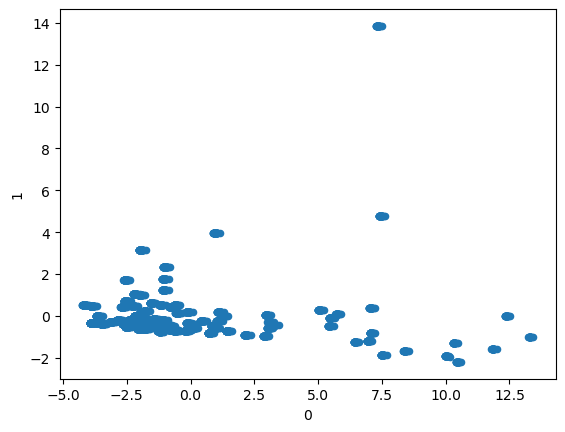

In [10]:
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X)
X_pca = pd.DataFrame(X_pca)
display(X_pca)
X_pca.plot.scatter(x=X_pca.columns[0],y=X_pca.columns[1]);

In [11]:
kmeans = KMeans(n_clusters=3).fit(X)

In [12]:
cluster_labels = {}
# Are we doing 1 indexing now?
cluster_labels[3] = kmeans.predict(X)
cluster_labels = pd.DataFrame(cluster_labels)

<AxesSubplot:xlabel='0', ylabel='1'>

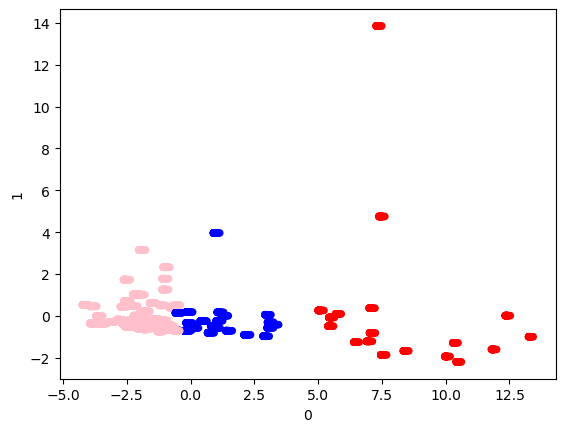

In [33]:
colorings = {}
# colorings[2] = cluster_labels[2].map({0: "Blue", 1: "Red"}) # This is a new pandas command for us that maps all 0 values to Blue, etc
colorings[3] = cluster_labels[3].map({0: "Blue", 1: "Red",2: "Pink"}) # This is a new pandas command for us that maps all 0 values to Blue, etc
# X_pca.plot.scatter(x=X_pca.columns[0],y=X_pca.columns[1],c=colorings[2])
X_pca.plot.scatter(x=X_pca.columns[0],y=X_pca.columns[1],c=colorings[3])

In [14]:
cluster_labels[3]

0       1
1       1
2       1
3       1
4       1
       ..
4432    2
4433    2
4434    2
4435    2
4436    2
Name: 3, Length: 4437, dtype: int32

In [23]:
combined_info = cities[['city', 'state']]
# combined_info['cluster'] = cluster_labels[3]
combined_info['PC1'] = X_pca[0]
combined_info['PC2'] = X_pca[1]
combined_info.head()

/tmp/ipykernel_9009/3495840646.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  combined_info['PC1'] = X_pca[0]
/tmp/ipykernel_9009/3495840646.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  combined_info['PC2'] = X_pca[1]


,city,state,PC1,PC2
0,New York,New York,7.385485,13.848617
1,Los Angeles,California,7.319265,13.849088
2,Chicago,Illinois,7.342039,13.848926
3,Houston,Texas,7.297391,13.849243
4,Phoenix,Arizona,7.356432,13.848823


In [23]:
# curious how some of our cities line up
# Yep, san diego expensive
# combined_info[combined_info['city'] == 'San Diego']
# combined_info[combined_info['city'] == 'Colorado Springs']
# # Not in the dataset
# combined_info[combined_info['city'] == 'San Luis Obispo']
# combined_info[combined_info['city'] == 'Seattle']

,city,state,cluster,PC1,PC2
17,Seattle,Washington,0,2.021802,0.074441


In [20]:
cluster_labels[3]

0       1
1       1
2       1
3       1
4       1
       ..
4432    2
4433    2
4434    2
4435    2
4436    2
Name: 3, Length: 4437, dtype: int32

In [24]:
df = combo.reset_index()[['city','state','field-study']]
df['label']  = cluster_labels[3]
df['label'].value_counts()

2    2878
0    1012
1     547
Name: label, dtype: int64

In [ ]:
for cluster in df['label'].unique():
    print(cluster)
    # display(df[df['label'] == cluster].head())
    display(df[df['label'] == cluster].groupby(['state', 'city'])['label'].value_counts())

Break majors by colleges (like the colleges within cal poly)

TODO: cluster df_degrees_over_career

## clustering by degrees over career

In [63]:
df_degrees_over_career = pd.read_csv('degrees-that-pay-back.csv')
df_degrees_over_career = df_degrees_over_career.set_index('Undergraduate Major')
for col in list(df_degrees_over_career):
    if col != 'Percent change from Starting to Mid-Career Salary':
        df_degrees_over_career[col] = df_degrees_over_career[col].str.strip('$')
        df_degrees_over_career[col] = df_degrees_over_career[col].str.replace(',', '')
    df_degrees_over_career[col] = df_degrees_over_career[col].astype(float)

df_degrees_over_career = df_degrees_over_career[['Starting Median Salary', 'Mid-Career Median Salary']]
df_degrees_over_career.head()

,Starting Median Salary,Mid-Career Median Salary
Undergraduate Major,,
Accounting,46000.0,77100.0
Aerospace Engineering,57700.0,101000.0
Agriculture,42600.0,71900.0
Anthropology,36800.0,61500.0
Architecture,41600.0,76800.0


<AxesSubplot:xlabel='0', ylabel='1'>

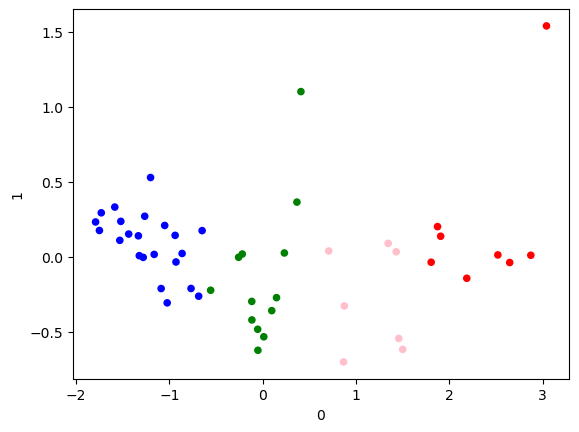

In [64]:
scaler = StandardScaler()
X = pd.DataFrame(scaler.fit_transform(df_degrees_over_career),columns=df_degrees_over_career.columns)
X
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X)
X_pca = pd.DataFrame(X_pca)
# display(X_pca)
# X_pca.plot.scatter(x=X_pca.columns[0],y=X_pca.columns[1]);
kmeans = KMeans(n_clusters=4).fit(X)

cluster_labels = {}
# Are we doing 1 indexing now?
cluster_labels[3] = kmeans.predict(X)
cluster_labels = pd.DataFrame(cluster_labels)

colorings = {}
# colorings[2] = cluster_labels[2].map({0: "Blue", 1: "Red"}) # This is a new pandas command for us that maps all 0 values to Blue, etc
colorings[3] = cluster_labels[3].map({0: "Blue", 1: "Red",2: "Pink", 3: 'Green'}) # This is a new pandas command for us that maps all 0 values to Blue, etc
# X_pca.plot.scatter(x=X_pca.columns[0],y=X_pca.columns[1],c=colorings[2])
X_pca.plot.scatter(x=X_pca.columns[0],y=X_pca.columns[1],c=colorings[3])

In [65]:
# df = X.reset_index()
df = df_degrees_over_career.reset_index()
df['label'] = cluster_labels[3]
df['label'].value_counts()

0    22
3    13
1     8
2     7
Name: label, dtype: int64

In [66]:
for cluster in sorted(df['label'].unique()):
    print(cluster)
    # display(df[df['label'] == cluster].head())
    display(df[df['label'] == cluster])

0


,Undergraduate Major,Starting Median Salary,Mid-Career Median Salary,label
3,Anthropology,36800.0,61500.0,0
5,Art History,35800.0,64900.0,0
6,Biology,38800.0,64800.0,0
11,Communications,38100.0,70000.0,0
15,Criminal Justice,35000.0,56300.0,0
16,Drama,35900.0,56900.0,0
18,Education,34900.0,52000.0,0
20,English,38000.0,64700.0,0
21,Film,37900.0,68500.0,0
23,Forestry,39100.0,62600.0,0


1


,Undergraduate Major,Starting Median Salary,Mid-Career Median Salary,label
1,Aerospace Engineering,57700.0,101000.0,1
8,Chemical Engineering,63200.0,107000.0,1
12,Computer Engineering,61400.0,105000.0,1
13,Computer Science,55900.0,95500.0,1
19,Electrical Engineering,60900.0,103000.0,1
30,Industrial Engineering,57700.0,94700.0,1
38,Mechanical Engineering,57900.0,93600.0,1
43,Physician Assistant,74300.0,91700.0,1


2


,Undergraduate Major,Starting Median Salary,Mid-Career Median Salary,label
10,Civil Engineering,53900.0,90500.0,2
14,Construction,53700.0,88900.0,2
17,Economics,50100.0,98600.0,2
22,Finance,47900.0,88300.0,2
35,Management Information Systems (MIS),49200.0,82300.0,2
37,Math,45400.0,92400.0,2
44,Physics,50300.0,97300.0,2


3


,Undergraduate Major,Starting Median Salary,Mid-Career Median Salary,label
0,Accounting,46000.0,77100.0,3
2,Agriculture,42600.0,71900.0,3
4,Architecture,41600.0,76800.0,3
7,Business Management,43000.0,72100.0,3
9,Chemistry,42600.0,79900.0,3
25,Geology,43500.0,79500.0,3
28,History,39200.0,71000.0,3
31,Information Technology (IT),49100.0,74800.0,3
33,International Relations,40900.0,80900.0,3
36,Marketing,40800.0,79600.0,3
